# SARSA with Gridworld

## Goal:

- Adapt from Monte Carlo
- SARSA

In [1]:
!git clone https://github.com/phizaz/chula_rl
%cd chula_rl
!pip install -e .

Cloning into 'chula_rl'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 50 (delta 12), reused 49 (delta 11), pack-reused 0
Unpacking objects: 100% (50/50), done.
/content/chula_rl
Obtaining file:///content/chula_rl
  Running setup.py develop for chula-rl


In [0]:
import gym
import chula_rl as rl
import os
import numpy as np
import random
from collections import deque, defaultdict
import pandas as pd
import matplotlib.pyplot as plt

## Step 1: Make Env

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: <class 'chula_rl.env.wrapper.ep_summary.EpisodeSummary'> doesn't implement 'reset' method, which is required for wrappers derived directly from Wrapper. Deprecated default implementation is used.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


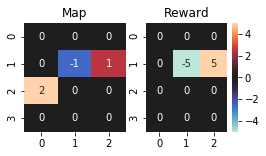

In [3]:
def make_env():
    env = rl.env.Gridworld(shape=(4, 3),
                           start=(2, 0),
                           goal=(1, 2),
                           move_reward=-1)
    env = rl.env.wrapper.ClipEpisodeLength(env, n_max_length=20)
    env = rl.env.wrapper.EpisodeSummary(env)
    return env


env = make_env()
env.reset()
env.render()

## Step 2: Define policy

SARSA with policy iteration (with only one-step policy evaluation) using moving average.

In [0]:
class SARSAPolicy(rl.policy.BasePolicy):

    def __init__(self, lr, discount_factor, observation_space, n_action):
        self.lr = lr
        self.discount_factor = discount_factor
        self.observation_space = observation_space
        self.n_action = n_action

        self.q = np.zeros(list(self.observation_space.high) +
                          [n_action])  # (s0, s1, a)

    def step(self, state):
        # code here ...
        # ...
        return np.argmax(self.q[tuple(state)])  # greedy action selection

    def optimize_step(self, data):
        # code here ...
        # ...

        s = np.array(data['s'])
        a = np.array(data['a'])
        r = np.array(data['r'])
        ss = np.array(data['ss'])
        aa = np.array(data['aa'])

        # code here ...
        # ...
        sa = np.concatenate((s, np.array([a])))
        ssaa = np.concatenate((ss, np.array([aa])))
        self.q[tuple(sa)] = self.q[tuple(sa)] + self.lr *(r + self.discount_factor * self.q[tuple(ssaa)]- self.q[tuple(sa)])

## Step 3: Define an explorer

Create `OneStepExplorer` to use with SARSA. You could look at the `EpisodeExplorer` for inspirations.

The `OneStepExplorer` should run a given policy only for ONE step then return what it sees.

It should return something like this from its `step` method: 

```
{
    's': current state,
    'a': action,
    'r': reward,
    'ss': next state,
    'aa': next action,
    'done': is done?,
}
```

In [0]:
class OneStepExplorer(rl.explorer.BaseExplorer):
    """explore the environment only one-step then returns the experience immediately"""
    def __init__(self, n_max_interaction, env):
        super().__init__(env)
        self.n_max_interaction = n_max_interaction
        self.last_s = self.env.reset()
        self.n_interaction = 0
        self.n_ep = 0
        

    def step(self, policy):
        if self.n_interaction >= self.n_max_interaction:
            raise rl.exception.InteractionExceeded()
            
        # code here
        # ...
        # data = the experience of the last step

        a = policy.step(self.last_s)
        ss, r, done, info = self.env.step(a)
        aa = policy.step(ss)
        data = {
            's' : self.last_s,
            'a' : a,
            'r' : r,
            'ss': ss,
            'aa': aa,
            'done' : done
        }
        
        self.last_s = ss
        self.n_interaction += 1

        
        if(done):
            self.last_s = self.env.reset()
            self.n_ep += 1
            self._update_stats(self.n_interaction, info['episode']['reward'])
        
        return data

Test the explorer:

In [107]:
rl.util.set_seed(0)
explorer = OneStepExplorer(1, make_env())
explorer.step(rl.policy.RandomPolicy(n_action=4))

{'a': 3,
 'aa': 3,
 'done': False,
 'r': -1,
 's': array([2, 0]),
 'ss': array([2, 1])}

Expected result: 

```
{'s': array([2, 0]),
 'a': 3,
 'r': -1,
 'ss': array([2, 1]),
 'aa': 3,
 'done': False}
```

Your result might vary, but the structure should be the same.

In [108]:
explorer.step(rl.policy.RandomPolicy(n_action=4))

InteractionExceeded: ignored

Expected result: `InteractionExceeded` exception raised.

## Running the algorithm

In [0]:
def run(policy, n_max_interaction):
    rl.util.set_seed(0) # predictable results
    env = make_env()
    env.reset()
    explorer = OneStepExplorer(n_max_interaction=n_max_interaction, env=env)

    while True:
        try:
            data = explorer.step(policy)
            policy.optimize_step(data)  # not defined
        except rl.exception.InteractionExceeded:
            break
            
    df = pd.DataFrame(explorer.get_stats()['history'])
    return df

max: 2


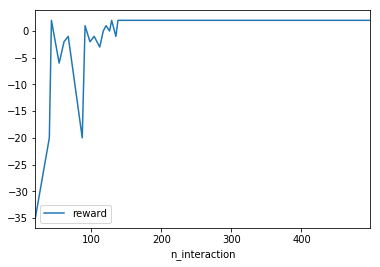

In [110]:
policy = SARSAPolicy(lr=0.1,
                     discount_factor=0.99,
                     observation_space=env.observation_space,
                     n_action=env.action_space.n)

stats = run(policy, 500)
print('max:', stats['reward'].max())
stats.plot(x='n_interaction', y='reward')

Expected result: In our implementation, we could get ~2 reward under 500 iteractions.

# Q1: Even without an explicit exploration like epsilon greedy, SARSA seems to work! Why is that the case? What works as an "implicit" exploration?

using not completed previous knowledge

# Q2: Show us then when an explicit exploration would be important? 

Create code blocks (and run them) as needed to proof your argument by comparing results SARSA vs. SARSA + epsilon greedy 

Plots are welcome.

In [0]:
class EpsilonGreedy(rl.policy.BasePolicyWrapper):
    def __init__(self, policy):
        self.policy = policy

    def step(self, state):
        # code here ...
        # ...
        epsilon = 0.3
        a = np.argmax(self.q[tuple(state)])  # greedy action selection
        prob = np.zeros(self.q.shape[-1], dtype=np.float)
        for i in range(len(prob)):
            if(i == a):
                prob[i] = 1 - epsilon + (epsilon/len(prob))
            else:
                prob[i] = epsilon/len(prob)

        return np.random.choice(len(prob), 1, p=prob)[0]

In [0]:
policy = SARSAPolicy(lr=0.1,
                     discount_factor=0.99,
                     observation_space=env.observation_space,
                     n_action=env.action_space.n)
policy = EpsilonGreedy(policy)

max: 2


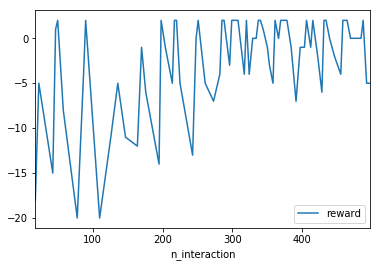

In [113]:
stats = run(policy, 500)
print('max:', stats['reward'].max())
stats.plot(x='n_interaction', y='reward')

Create blocks as needed ...